## 1. Importing Libraries

In [82]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

## 2. Loading and Preparing Data for 2-Class Classification

In [83]:
# File paths
ascending_file = "/home/hongwcai/LSS/ECE5995_AorticWall/OldResults/plots_box/AscendingAll.xlsx"

# Load data
df_normal = pd.read_excel(ascending_file, sheet_name="Normal")
df_aneurysmal = pd.read_excel(ascending_file, sheet_name="Aneurysmal")

# Select columns and label data
columns = ["Centerline Length", "Mean Diameter", "Max Diameter", "Volume"]
df_normal = df_normal[columns]
df_aneurysmal = df_aneurysmal[columns]

df_normal["Label"] = 0
df_aneurysmal["Label"] = 1

# Combine data
df_binary = pd.concat([df_normal, df_aneurysmal], ignore_index=True)

# Check for missing values and data types
print(df_binary.isnull().sum())
print(df_binary.dtypes)

# Fill missing values or drop rows with missing values
df_binary = df_binary.dropna()

# Ensure all columns are of numeric type
df_binary = df_binary.astype(float)

# Split data
X_binary = df_binary[columns]
y_binary = df_binary["Label"]
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

Centerline Length    0
Mean Diameter        0
Max Diameter         0
Volume               0
Label                0
dtype: int64
Centerline Length    float64
Mean Diameter        float64
Max Diameter         float64
Volume                 int64
Label                  int64
dtype: object


## 3. Training and Evaluating the 2-Class Model

2-Class Classification Accuracy: 0.7209
2-Class Classification ROC AUC Score: 0.8004
2-Class Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75        24
         1.0       0.68      0.68      0.68        19

    accuracy                           0.72        43
   macro avg       0.72      0.72      0.72        43
weighted avg       0.72      0.72      0.72        43



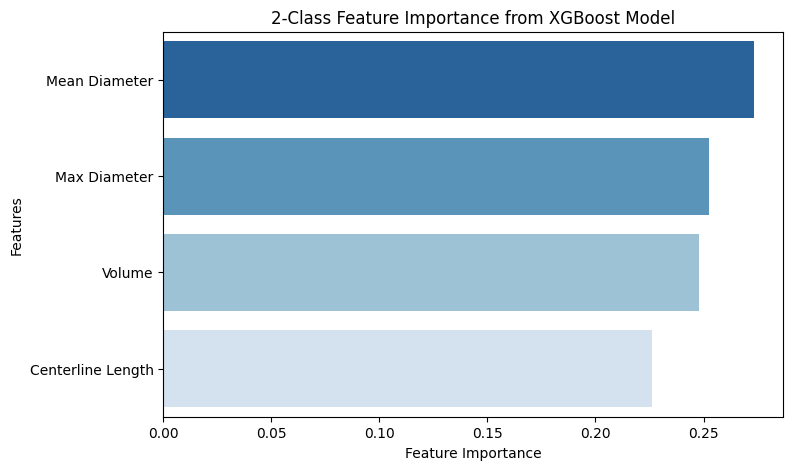

In [84]:
# Define and train the model
model_binary = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    max_depth=3,
    learning_rate=0.01,
    n_estimators=1000,
    subsample=0.1,
    colsample_bytree=0.2
)
model_binary.fit(X_train_binary, y_train_binary)

# Make predictions and evaluate the model
y_pred_binary = model_binary.predict(X_test_binary)
y_pred_proba_binary = model_binary.predict_proba(X_test_binary)[:, 1]
accuracy_binary = accuracy_score(y_test_binary, y_pred_binary)
roc_auc_binary = roc_auc_score(y_test_binary, y_pred_proba_binary)

print(f"2-Class Classification Accuracy: {accuracy_binary:.4f}")
print(f"2-Class Classification ROC AUC Score: {roc_auc_binary:.4f}")
print("2-Class Classification Report:\n", classification_report(y_test_binary, y_pred_binary))

# Feature importance visualization
feature_importance_binary = model_binary.feature_importances_
importance_df_binary = pd.DataFrame({"Feature": columns, "Importance": feature_importance_binary})
importance_df_binary = importance_df_binary.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df_binary, hue="Feature", palette="Blues_r", legend=False)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("2-Class Feature Importance from XGBoost Model")
plt.show()

# Section 2: Multi-Class Classification
## 4. Loading and Preparing Data for Multi-Class Classification

In [85]:
# File paths
ascending_file = "/home/hongwcai/LSS/ECE5995_AorticWall/OldResults/plots_box/AscendingAll.xlsx"
aorta_all_file = "/home/hongwcai/LSS/ECE5995_AorticWall/OldResults/plots_box/AortaRoot2D+3DAll.xlsx"

# Load data
df_normal = pd.read_excel(ascending_file, sheet_name="Normal")
df_aneurysmal = pd.read_excel(ascending_file, sheet_name="Aneurysmal")
df_aorta_normal = pd.read_excel(aorta_all_file, sheet_name="Normal")
df_aorta_aneurysmal = pd.read_excel(aorta_all_file, sheet_name="Aneurysmal")

# Rename columns
feature_2d_3d_columns = [
    "Laplace Radius-LCS", "Laplace Radius-RCS", "Laplace Radius-NCS",
    "Area-LCS", "Area-RCS", "Area-NCS",
    "Volume-LCS", "Volume-RCS", "Volume-NCS",
    "Height-LCS", "Height-RCS", "Height-NCS"
]
df_aorta_normal = df_aorta_normal.rename(columns={df_aorta_normal.columns[i]: feature_2d_3d_columns[i-1] for i in range(1, 13)})
df_aorta_aneurysmal = df_aorta_aneurysmal.rename(columns={df_aorta_aneurysmal.columns[i]: feature_2d_3d_columns[i-1] for i in range(1, 13)})

# Select and combine data
feature_columns = ["Centerline Length", "Volume"]
df_normal = df_normal[["ID"] + feature_columns + ["Max Diameter"]]
df_aneurysmal = df_aneurysmal[["ID"] + feature_columns + ["Max Diameter"]]
df_aorta_normal = df_aorta_normal[["ID"] + feature_2d_3d_columns]
df_aorta_aneurysmal = df_aorta_aneurysmal[["ID"] + feature_2d_3d_columns]

df = pd.concat([df_normal, df_aneurysmal], ignore_index=True)
df_aorta = pd.concat([df_aorta_normal, df_aorta_aneurysmal], ignore_index=True)
df = df.merge(df_aorta, on="ID", how="left")
df.drop(columns=["ID"], inplace=True)

# Categorize diameter in mm
def categorize_diameter(value):
    if value < 45:  # <45mm
        return 0
    elif 45 <= value < 50:  # [45, 50)
        return 1
    elif 50 <= value < 55:  # [50, 55)
        return 2
    else:  # ≥55mm
        return 3

df["Label"] = df["Max Diameter"].apply(categorize_diameter)
df.drop(columns=["Max Diameter"], inplace=True)

# Check for missing values and data types
print(df.isnull().sum())
print(df.dtypes)

# Fill missing values or drop rows with missing values
df = df.dropna()

# Ensure all columns are of numeric type
df = df.astype(float)

Centerline Length     0
Volume                0
Laplace Radius-LCS    8
Laplace Radius-RCS    8
Laplace Radius-NCS    8
Area-LCS              8
Area-RCS              8
Area-NCS              8
Volume-LCS            8
Volume-RCS            8
Volume-NCS            8
Height-LCS            8
Height-RCS            8
Height-NCS            8
Label                 0
dtype: int64
Centerline Length     float64
Volume                  int64
Laplace Radius-LCS    float64
Laplace Radius-RCS    float64
Laplace Radius-NCS    float64
Area-LCS              float64
Area-RCS              float64
Area-NCS              float64
Volume-LCS            float64
Volume-RCS            float64
Volume-NCS            float64
Height-LCS            float64
Height-RCS            float64
Height-NCS            float64
Label                   int64
dtype: object


## 5. Splitting Data and Training the Multi-Class Model

In [86]:
# Feature columns
feature_columns = feature_columns + feature_2d_3d_columns

# Split data
X = df[feature_columns]
y = df["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define and train the model
model_multi = xgb.XGBClassifier(
    objective="multi:softprob",  
    eval_metric="mlogloss",  
    num_class=4,  
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.3,
    colsample_bytree=0.6,
    min_child_weight=3,
    gamma=0.2,
    random_state=42
)
model_multi.fit(X_train, y_train)
print('Model is trained.')

Model is trained.


## 6. Evaluating the Multi-Class Model

Multi-Class Classification Accuracy: 0.8095
Multi-Class Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      1.00      0.93        32
         1.0       0.50      0.17      0.25         6
         2.0       0.33      0.33      0.33         3
         3.0       0.00      0.00      0.00         1

    accuracy                           0.81        42
   macro avg       0.42      0.38      0.38        42
weighted avg       0.75      0.81      0.77        42



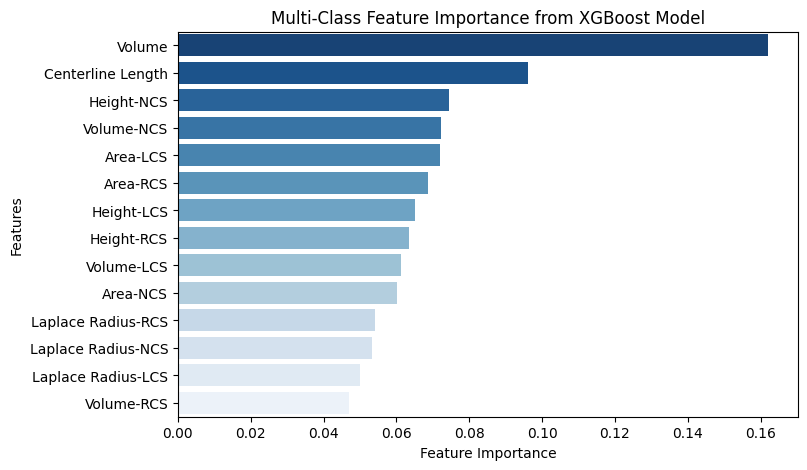

In [87]:
# Make predictions and evaluate the model
y_pred_multi = model_multi.predict(X_test)
y_pred_proba_multi = model_multi.predict_proba(X_test)
accuracy_multi = accuracy_score(y_test, y_pred_multi)

print(f"Multi-Class Classification Accuracy: {accuracy_multi:.4f}")
print("Multi-Class Classification Report:\n", classification_report(y_test, y_pred_multi, zero_division=0))

# Feature importance visualization
feature_importance_multi = model_multi.feature_importances_
importance_df_multi = pd.DataFrame({"Feature": feature_columns, "Importance": feature_importance_multi})
importance_df_multi = importance_df_multi.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df_multi, hue="Feature", palette="Blues_r", legend=False)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Multi-Class Feature Importance from XGBoost Model")
plt.show()

## 7. SHAP Values for Model Interpretation

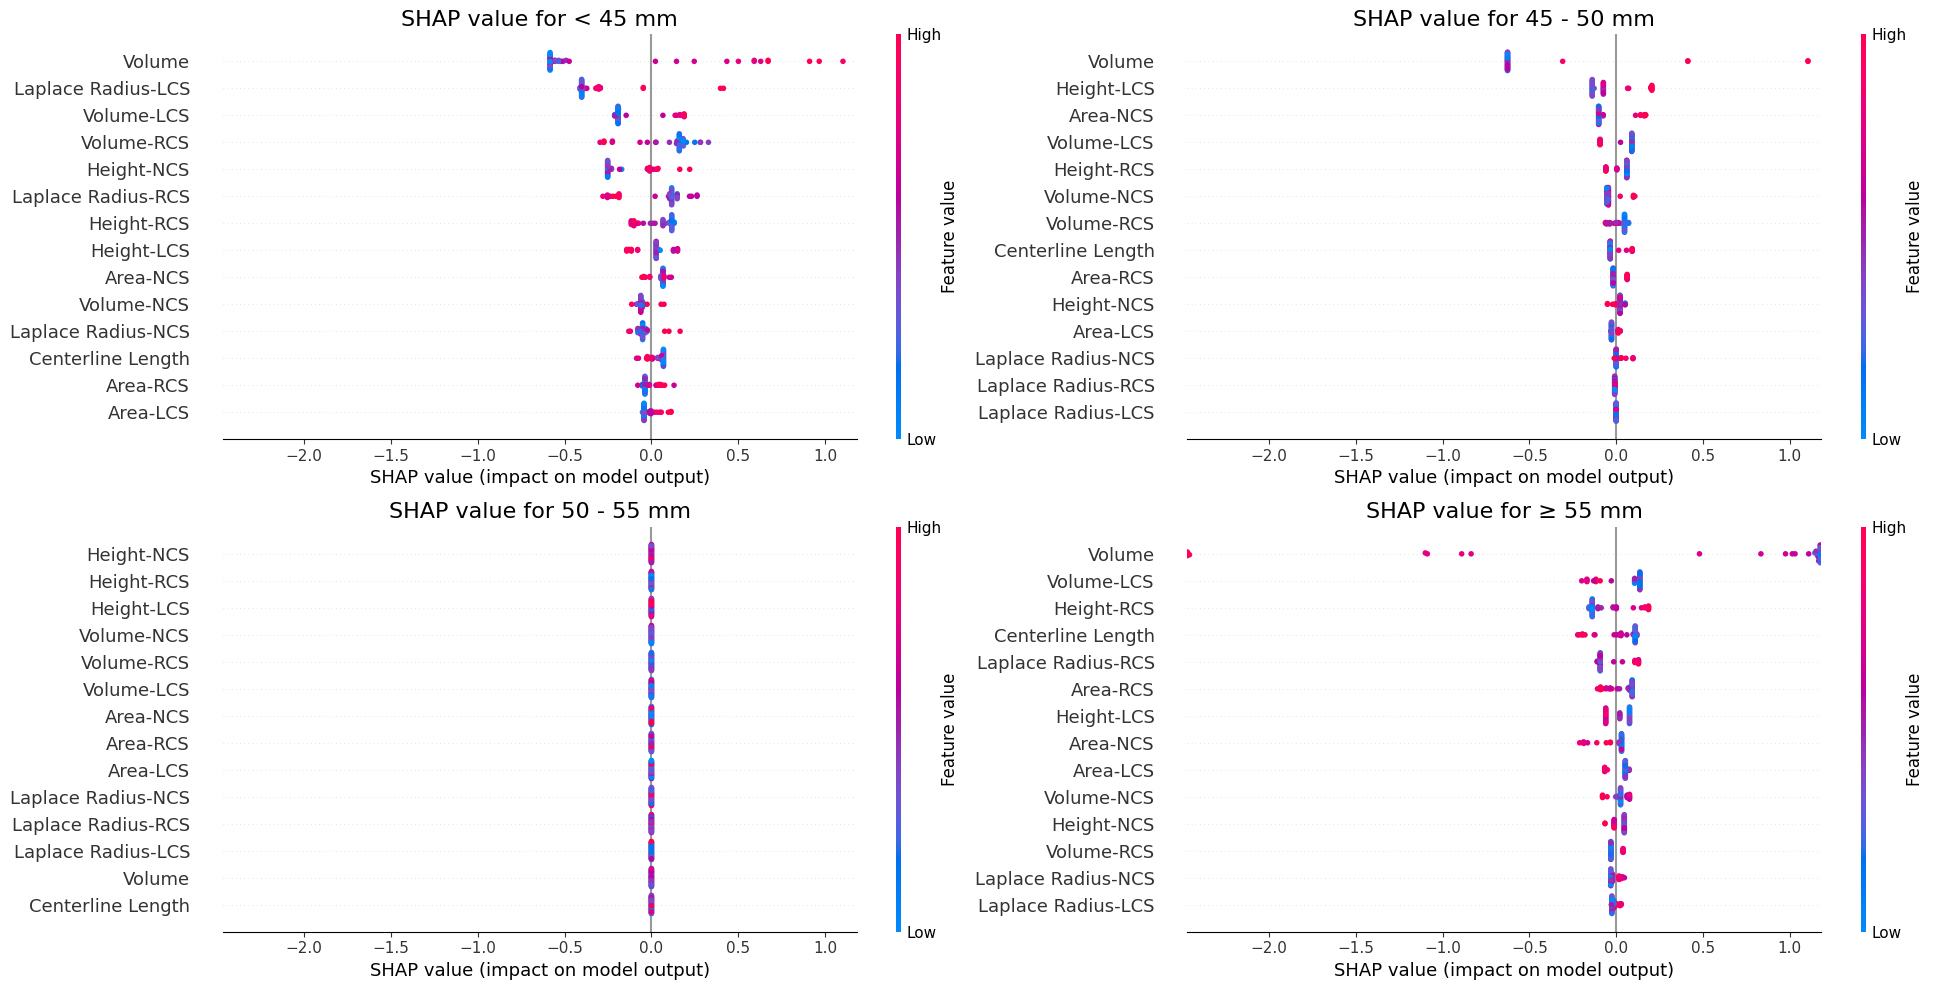

In [88]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

class_names = [
    "< 45 mm",   # Class 0
    "45 - 50 mm",  # Class 1
    "50 - 55 mm",  # Class 2
    "≥ 55 mm"  # Class 3
]

shap_min = np.min(shap_values)
shap_max = np.max(shap_values)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))  

for i, ax in enumerate(axes.flat):  
    shap.summary_plot(shap_values[:, :, i], X_test, feature_names=feature_columns, show=False, plot_size=(20, 10))
    ax.set_title(f"SHAP value for {class_names[i]}", fontsize=16)  
    ax.set_xlim([shap_min, shap_max])
    plt.sca(ax)  

plt.tight_layout()
plt.show()